<a href="https://colab.research.google.com/github/zmess24/personal-website-nextjs/blob/main/tf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After almost three months of teaching myself PyTorch (and largely image classification), I've started to pivot into my real passion within the field of deep learning - natural language processing (NLP) and natural language generation (NLG). And if you're reading this post, my guess is that you can guess why. With the rise of powerful LLM models like ChatGPT, Claude, Gemini, ect over the last two years, it feels like we are entering a new age of technology akin to the dot com of the early 2000's, where advanced AI models will play an increasingly important part of our every day lives. For my part, I know I use LLM's almost daily to increase my work efficiency.

After having finished Daniel Bourke's [PyTorch for Deep Learning online course](https://www.udemy.com/course/pytorch-for-deep-learning/), I've taken on progressing through Delip Rao & Brian McMahan's [Natural Language Processing with PyTorch](https://www.oreilly.com/library/view/natural-language-processing/9781491978221/) textbook, which has been endlessly facinating. It's hard to believe, but I'm even more excited to finish this book than I was to learn deep learning in the first place!

The topic of today's post is heavily inspired from chapter 1 of that textbook, and will be dedicated to covering TF-IDF vectorization. Without futher ado, let's jump into it.

## Library Import

We're not going to be using anything fancy as all of the code we'll be writing is going to be from scatch, so the only things we'll need are a few data visualization and computing libraries. I've covered most of these before in previous posts, but if you are unfamiliar with any of them, feel free to look them up!

In [337]:
# Computing Libraries
import numpy as np
import math

# Data Visualization Libraries
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Typings
from typing import List, Dict

## What is TF-IDF?

TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a statistical measure used to evaluate how important a word is to a collection of documents. It is one of the oldest NLP methods around for performing tasks like relevance ranking, and while newer methods like word embeddings (Word2Vec, GloVe) and transformer-based models (BERT, GPT) have become more popular recently due to their ability to capture deeper semantic meanings of words and contexts, TF-IDF remains a quick, low cost solution for many simple projects.

As the name implies, there are two main components of TF-IDF:

* **Term Frequency (TF)**: TF measures the frequency of a word in a document, or the number of times a word appears in a document divided by the total number of words in that document. The idea is to understand how frequently a term occurs in a single document.
* **Inverse Document Frequency (IDF)**: IDF measures the importance of a term across a set of documents. The idea behind IDF is that a given word is not very informative if it appears in many documents. IDF is calculated as the logarithm of the number of documents divided by the number of documents that contain the word.

The goal of today's post will be to be break down each of these terms into easy to understand componenets. We'll also go through an exciting example at the end, where we'll use TF-IDF vectorization to rank order a collection of fake NBA article titles given a search term.

Before getting to the individual `TF` and `IDF` formulas, we'll need to perform a little string preprocessing in order to prepare our data for use in those formulas. So let's start there.

## String Preprocessing and Tokenization

To begin, let's define a set of documents to work with, and for simplicities sake, we'll keep the documents very short in order to make the sequence of steps we progress through easier to understand in practice. The text used is mostly from an example in chapter 1 of [Natural Langauge Processing with PyTorch](https://www.oreilly.com/library/view/natural-language-processing/9781491978221/), although I've converted it into a Haiku poem to add a little flavor after being inspired by FX's Shogun series.

In [364]:
documents = [
    "Time flies, flies like an arrow.",
    "Fruit flies like apples",
    "Moments in time, sweet and narrow"
]

In order to prepare our documents to be converted into a corpus (a vocabulary of all the words contained in our documents), we'll need to perform some data-preprocessing by removing any special characters from each sentence and lowercasing each word. It's important to highlight that string santitation methods may differ depending on the task, but for our purposes, we're keeping it simple. To help us, we'll write two seperate functions.

The first function, called `santize_string()`, will remove all special characters from each document while also converting each word to lowercase.

In [339]:
def sanitize_documents(documents: List[str]):
  special_chars = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  num_documents = len(documents)
  sanitized_documents = documents.copy()

  for i in range(num_documents):
    # Remove special characters
    for char in sanitized_documents[i]:
      if char in special_chars:
        sanitized_documents[i] = sanitized_documents[i].replace(char, '')

    # Lowercase document string
    sanitized_documents[i] = sanitized_documents[i].lower()

  return sanitized_documents

Let's try it out on our haiku poem:

In [365]:
documents = sanitize_documents(documents)
documents

['time flies flies like an arrow',
 'fruit flies like apples',
 'moments in time sweet and narrow']

The second function, called `tokenize()`, will simply accept a document string as an argument, and return an in-order list of the words in the string.

In [341]:
def tokenize(string: str):
  return string.split()

for document in documents:
  print(tokenize(document))

['time', 'flies', 'flies', 'like', 'an', 'arrow']
['fruit', 'flies', 'like', 'apples']
['moments', 'in', 'time', 'sweet', 'and', 'narrow']


## Building a Corpus

With our `sanitize_documents()` and `tokenize()`, functions complete, we're ready to build our corpus. As stated previously, the goal of a corpus is to create a vocabulary dictionary of all the unqiue words contained in our list of documents.

Our `create_corpus()` function will be very straight forward to implement - we'll simply return a dictionary of every unique word mapped to an index or fixed position. We'll also sort the corpus alpabetically just to make it easier to read.

In [366]:
def create_corpus(documents: List[str]):
  corpus = {}
  words = []

  for document in sanitize_documents(documents):
    for word in tokenize(document):
      if word not in words:
        words.append(word)

  for i, word in enumerate(sorted(words)):
    corpus[word] = i

  return corpus

corpus = create_corpus(documents)
corpus

{'an': 0,
 'and': 1,
 'apples': 2,
 'arrow': 3,
 'flies': 4,
 'fruit': 5,
 'in': 6,
 'like': 7,
 'moments': 8,
 'narrow': 9,
 'sweet': 10,
 'time': 11}

## One-Hot Encoding

Let's now visualize our corpus by representing each word in a one-hot vector. In case you've never heard of that term before, one-hot encoding is a popular technique used to represent categorical variables as binary vectors, where each category value is converted into a vector that has length equal to the number of unique categories in the data set. The one-hot encoded vector is displayed as all $0$'s, except for a single $1$ in the position that corresponds to the category.

We can create a one-hot encoding vector by initializing a vector of $0$'s equal to the length of the vocabulary in our corpus, and for a given word replace it's index (provided by looking up it's index in our corpus) in the vector with a $1$.

For example, one-hot encoding the word "time" based on our document collection would look like the following:

In [367]:
def one_hot_encoding(word, corpus):
    vector = [0] * len(corpus)
    if word in corpus:
        index = corpus[word]
        vector[index] = 1

    return vector

one_hot_encoding("time", corpus)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Let's build a one-hot encoding mapping for our full corpus with a little help from `seaborn` and `pandas` to better help us understand the encoding index mappings:

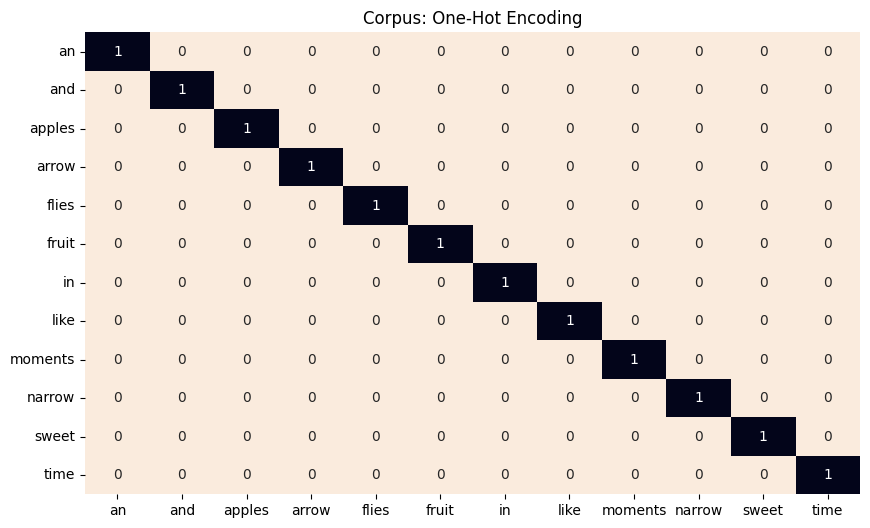

In [344]:
def build_one_hot_table(corpus, document):
  data = []
  for word in document:
    vector = one_hot_encoding(word, corpus)
    data.append(vector)

  return pd.DataFrame(data, columns=corpus.keys(), index=document)

def plot_encoding(data: List[int], title: str, corpus: Dict[str, int], index: List[str]):
  pd.DataFrame(data, columns=corpus.keys(), index=index)
  # Create sns plot
  plt.figure(figsize=(10, len(index) * 0.5))
  map = sns.heatmap(data, annot=True, cmap="rocket_r", cbar=False, xticklabels=corpus.keys(), yticklabels=index)
  map.set_xticklabels(map.get_xticklabels(), rotation=0)  # Rotate x labels horizontally
  map.set_yticklabels(map.get_yticklabels(), rotation=0)   # Keep y labels horizontal
  plt.title(f"{title}")

table = build_one_hot_table(corpus, list(corpus.keys()))
plot_encoding(data=table, title="Corpus: One-Hot Encoding", corpus=corpus, index=list(corpus.keys()))

With these relationships in mind, let's now one-hot encode the second document in our dummy data, `fruit flies like apples`:

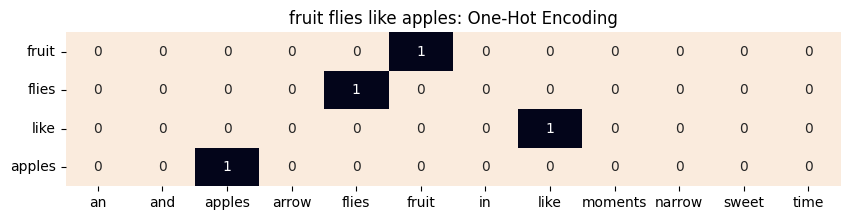

In [345]:
table = build_one_hot_table(corpus, tokenize(documents[1]))
plot_encoding(data=table, title=f"{documents[1]}: One-Hot Encoding", corpus=corpus, index=documents[1].split())

It is common when using one-hot encoding to "collapse" the one-hot representations of the provided document into a single binary encoding vector, where $0$'s and $1$'s are used to represent the presence or absense of a provided word.

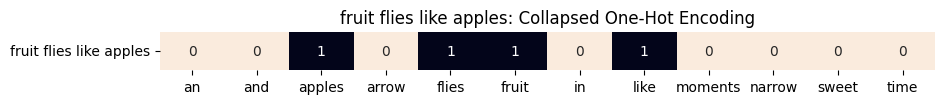

In [346]:
def one_hot_encoding_collapsed(document, corpus):
    vector = [0] * len(corpus)
    for word in tokenize(document):
      if word in corpus:
          index = corpus[word]
          vector[index] = 1

    return vector

encoding = one_hot_encoding_collapsed(documents[1], corpus)
plot_encoding(data=[encoding], title=f"{documents[1]}: Collapsed One-Hot Encoding", corpus=corpus, index=[documents[1]])

## Term Frequency (TF) Representation

Term Frequency (or TF), as you might expect, is the number of times a word appears in a document relative to the total number of words in the document. The beauty of using one-hot encoding is that we've already laid the  foundation for calculating TF - we can simply sum the one-hot vectors of each of the constituant words in a provided document, before dividing the resulting vector by the number of words in the document to get the frequncies. If done correctly, the sum of each word frequency in the vector should total $1$.

Let's go through an example together:

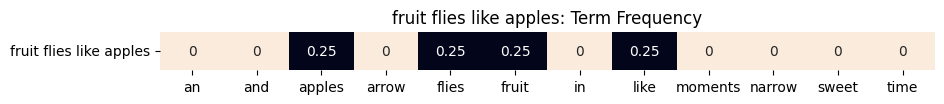

In [368]:
def create_document_tf(document: str, corpus: Dict[str, int]):
  vector = [0] * len(corpus)

  for word in tokenize(document):
    if word in corpus:
      index = corpus[word]
      vector[index] += 1

  total_words = np.sum(vector)

  for i in range(len(vector)):
    vector[i] /= total_words
  return vector

tf_encoding = create_document_tf(documents[1], corpus)
plot_encoding(data=[tf_encoding], title=f"{documents[1]}: Term Frequency", corpus=corpus, index=[documents[1]])

Makes sense! Since `fruit flies like apples` is a four word phrase with each word appearing only once, it's logical that the term frequencies would be $0.25$ each. Let's now look at the TF for our entire document collection by defining a `tf` function.

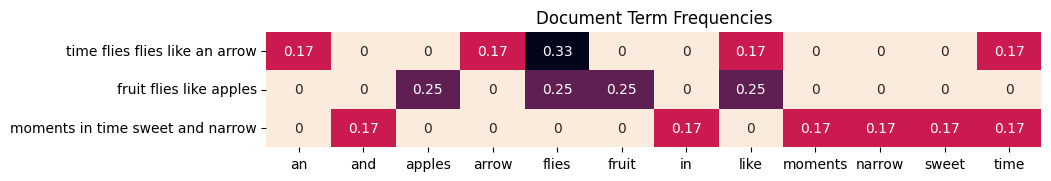

In [369]:
def tf(documents: List[str], corpus: Dict[str, int]):
  vectors = []
  for document in documents:
    vector = create_document_tf(document, corpus)
    vectors.append(vector)
  return vectors

tf_vectors = tf(documents, corpus)

plot_encoding(data=tf_vectors, title="Document Term Frequencies", corpus=corpus, index=documents)

With a `tf` function in place, we're ready to move on the next component in TF-IDF!

## Inverse Document Frequency (IDF) Representation

Inverse Document Frequency (IDF) is a statistical measure of how important a word is to a document in a collection or corpus. As stated previously, the rationale behind IDF is that terms that appear in many different documents are less informative and distinguishing than those that appear fewer. By scaling down the weights of common terms and scaling up the weights of rare terms, IDF helps adjust for the fact that some words are generally more common than others.

As an example, the word "the" is an extremely common word in the english language, and therefore, probably would not hold much semantic importance among the document collection. However, a term like "basketball" that appears frequently in one document but fewer in others would have a higher IDF, signifying its importance among documents where it appears.

The basic formula for calculating IDF is as follows:

$$\text{IDF}(t) = \log \left(\frac{N}{\text{DF}(t)}\right)$$

Where:

* $\text{IDF}(t)$ represents the inverse document frequency of term
$t$.
* $N$ is the total number of documents in the corpus.
* $\text{DF}(t)$ is the number of documents that contain the term.
* $\text{log}$ is the logarithm function, which can be base 10, base e (natural logarithm), or another base depending on the context or implementation.

It's important to note that a modified version of the formula is commonly used to account for smoothing, which is a technique aimed at reducing the potential for words with $0$ to minimal frequencies from distorting the resulting IDF values. Smoothing primarily helps prevent the following two scenarios:

* **Prevent Zero Division**: In its simplest form, the IDF formula could lead to a division by zero if a term does not appear in any document (although this is rare). Smoothing adds constants (e.g $1$) to the formula to ensure that there are no zero denominators.
* **Softening Impact of Rare Words**: Extremely rare words (appearing in very few documents) receive very high IDF scores in our basic formula, which could overemphasize their importance. Smoothing moderates these scores by ensuring that the IDF values increase smoothly rather than abruptly as the document frequency decreases.

For our purposes, we will use the IDF formula used by `scikit-learn'`[TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) method in implementing our own solution. The modified version is as follows:

$$\text{IDF}(t) = \log \left(\frac{N + 1}{\text{DF}(t) + 1}\right) + 1$$

With the a matmatical understanding of IDF works, let's go ahead and implement the formula in code.

First, let's solve the $\text{DF}$ (document frequency) portion of the formula by building a `count_terms` function, which will accept a list of documents as an argument and for each term, return the number of documents each word appears in.


In [349]:
def count_terms(documents: List[str]):
  # Initialize a dictionary to count the document frequencies of each term
  df_counts = {}

  # Loop through each document
  for document in documents:
    # Use a set to find unique terms in the document
    unique_terms = set(document.split())

    # Update the document frequency count for each unique term
    for term in unique_terms:
        if term in df_counts:
            df_counts[term] += 1
        else:
            df_counts[term] = 1

  return df_counts

count_terms(documents)

{'time': 2,
 'arrow': 1,
 'like': 2,
 'an': 1,
 'flies': 2,
 'apples': 1,
 'fruit': 1,
 'moments': 1,
 'in': 1,
 'narrow': 1,
 'and': 1,
 'sweet': 1}

Now we can write our `idf` function by simply iterating through our `term_count` dictionary and plug in the $\text{DF}$ for each term into the formula laid out above.

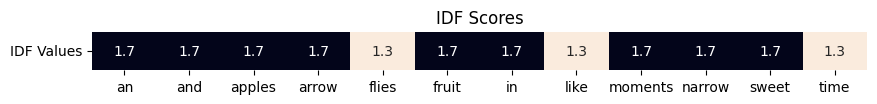

In [350]:
def idf(documents: List[str], corpus: Dict[str, int]):
  N = len(documents)
  word_count = count_terms(documents)
  idf_values = []
  # Calculate IDF for each term
  for term, df in sorted(word_count.items()):
      idf = np.log((1 + N) / (1 + df)) + 1
      idf_values.append(idf)

  return idf_values


idf_values = idf(documents, corpus)
plot_encoding(data=[idf_values], title="IDF Scores", corpus=corpus, index=["IDF Values"])


## The TF-IDF Formula

With both our `tf` and `idf` functions ready to go, we're almost ready for wrap everything up! The full equation for TF-IDF can be expressed as:

$$\text{TF-IDF}_{\text{norm}}(t, d) = \frac{\text{TF-IDF}(t, d)}{\sqrt{\sum_{t \in d} (\text{TF-IDF}(t, d))^2}}$$

Where:

* $\text{TF-IDF}_{\text{norm}}(t, d)$ represents the normalized TF-IDF score for term $t$ in document $d$.
* $\text{TF-IDF}(t, d)$ is the raw TF-IDF score for a given term.
* The demonimantor, $\sqrt{\sum_{t \in d} (\text{TF-IDF}(t, d))^2}$, is the L2 norm of the TF-IDF vector, which normalizes the vector to a unit length. This ensures that the length of the TF-IDF vector does not affect the similarity calculations between documents.

In this context, $\text{TF-IDF}(t, d)$ is simply the dot product of the TF-IDF vectors for each document, which we have already previously defined. I covered dot product multiplication in one of my previous posts, [Fun with Linear Algebra and Matricies](https://www.zacmessinger.com/posts/fun-with-linear-algebra-and-matrices) if you are intested in learning more on the specifics of how it is performed. The equation for the raw TF-IDF scores can be expressed as:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

The only piece missing from our implementation is the normaliation piece, so let's hit on that quickly.

## L2 Normalization

While there are a couple different techniques for applying normalization, by far the most common is L2 normalization, which unsuprisingly is the default normalization technique used in libraries like [scikit-learn's TfidfTransformer method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).
The premise of L2 normalization involves adjusting the components of the vector so that it's Euclidean length (or magnitude) becomes exactly 1. If this sounds abstract for you, here’s a more relatable explanation.

Imagine you have several arrows of different lengths pointing in various directions, and we want to compare their directions agnostic of their length. In order to do so, you would shorten all the arrows to  same length, but ensure they still point in the same directions as they did originally. That’s essentially what L2 normalization does with vectors in mathematics or data science.

The formula we will use for L2 normalization is:


$$
\mathbf{v}_{\text{norm}} = \frac{\mathbf{v}}{\sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}}
$$

Mathmatically, this means we apply the square root of the sum of the squares for the vector as a denominator for each element in the vector.

For example,

$
A = [1, 2, 3]
$

Would become:

$
A = [\frac{1}{3.74}, \frac{2}{3.74}, \frac{3}{3.74}]
$

Programatically, L2 normalization can be expressed like so:

In [351]:
def l2_normalization(vector: List[float]):
  l2_norm = np.sqrt(np.sum(np.square(vector)))
  return vector / l2_norm

As an example, if we apply this `l2_normalization` function to the array `[1, 2, 3, 4]`, we would the following normalized values, which aligns with our example above:

In [361]:
l2_normalization([1,2,3])

array([0.26726124, 0.53452248, 0.80178373])

We can prove that the magnitude of this resulting vector equals $1$ by squaring each component:

In [362]:
sum = 0

for value in l2_normalization([1,2,3]):
  sum += value ** 2

round(sum)

1

## Putting it all together

With all of the individual components of our TF-IDF formula in place, it's finally time to put it all together. As discussed previously, the steps we will define in our `tfidf` function will be to:

1. Generate our TF matrix using our `tf` function.
2. Generate our IDF vector using our `idf` function.
3. Generate our TF-IDF matrix by applying dot product multiplication on between TF matrix and our IDF vector.
4. Apply L2 normalization row by row of the resulting matrix to get our final TF-IDF scores.

Here is what our final `tfidf` function looks like, and what our resulting TF-IDF vectors look like for our original collection of documents:

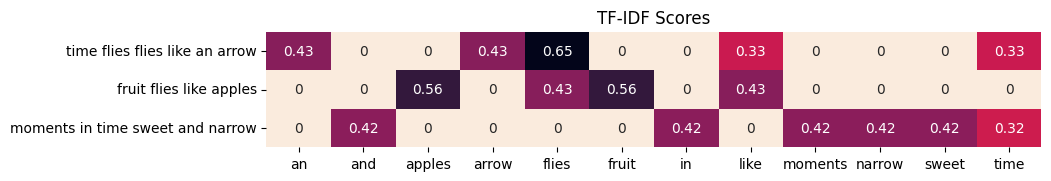

In [354]:
def tfidf(documents: List[str], corpus: Dict[str, int]):
  tf_vectors = np.array(tf(documents, corpus))
  idf_values = np.array(idf(documents, corpus))
  tfidf_vectors = tf_vectors * idf_values

  for i in range(len(tfidf_vectors)):
    tfidf_vectors[i] = l2_normalization(tfidf_vectors[i])

  return tfidf_vectors

tfidf_vectors = tfidf(documents, corpus)
plot_encoding(data=tfidf_vectors, title="TF-IDF Scores", corpus=corpus, index=documents)

Just to fact check our work, let's compare our implementation to that of `scikit-learns`, which most of our TF-IDF formula's were modeled after:

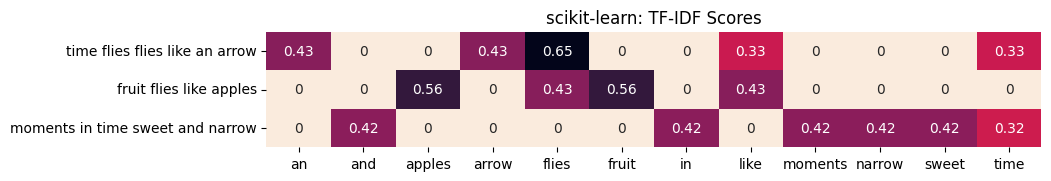

In [355]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
sklearn_tfidf = vectorizer.fit_transform(documents).toarray()
plot_encoding(data=sklearn_tfidf, title="scikit-learn: TF-IDF Scores", corpus=corpus, index=documents)

Beautiful, our custom `tfidf` function scores are 1:1 w scores with that of scikit-learn's `TfidfVectorizer`! As a final test and to show the value of the TF-IDF algorithm, let's perform relevance ranking on a collection of documents given a provided query. To make our use case more in line with how TF-IDF might be used in industry, we'll run TF-IDF on a collection of fake NBA article titles, and then return a list of the most relevant articles for the entered search term, which for this example will be `"NBA Lebron James Lakers"`.

In [356]:
# Sample documents
documents = [
    "The Rise of Luka Dončić: How the Mavericks' Star Is Reshaping the NBA",
    "LeBron's Legacy: Analyzing LeBron James' Impact with the Lakers",
    "Warriors Unveiled: A Closer Look at Golden State's Strategy for Dominance",
    "Giannis at the Helm: Can the Bucks Secure Another Championship under Antetokounmpo?",
    "Kevin Durant's Journey: From MVP to the Suns' Leader",
    "Rookie Watch: Victor Wenbenyama's First Season with the Spurs",
    "Inside the Heat Culture: Jimmy Butler and Miami's Pursuit of Excellence",
    "Chris Paul's Influence: Steering the Suns Towards NBA Finals Glory"
]

search_term = ["NBA Lebron James Lakers"]

To perform this exercise, we'll need two additional formulas to help us:

* `transform`, which will produce a vector of the TF-IDF scores for each term in the given query against our original corpus of documents (e.g article titles). This function will more or less be a re-implementaiton of our original `tfidf` function above.
* `cosine_similarity`, which will calculate and return the cosine simarlities between each document in our original TF-IDF matrix and our transformed query TF-IDF vector.

If you need a refresher on what a cosine is, the cosine of an angle in a right triangle is a trigonometric function that relates the angle to the lengths of the sides of the triangle. Specifically, the cosine of an angle is the ratio of the length of the adjacent side to the length of the hypotenuse, which in our context means we're measuring how close the angle produced by our query vector and each article title vector are to each other. Here is graphic I found from Math is Fun explaining this concept visually:

![](https://www.mathsisfun.com/algebra/images/sin-cos-tan.svg)

Let's define our `transform` and `cosine_similarity` functions below:

In [357]:
def transform(documents: List[str], query=List[str]):
  documents = sanitize_documents(documents)
  corpus = create_corpus(sanitize_documents(documents))
  query = sanitize_documents(query)

  tf_vectors = np.array(tf(query, corpus))
  idf_values = np.array(idf(documents, corpus))
  tfidf_vectors = tf_vectors * idf_values

  for i in range(len(tfidf_vectors)):
    tfidf_vectors[i] = l2_normalization(tfidf_vectors[i])

  return tfidf_vectors

def cosine_similarity(vector: List[float], matrix: List[float]):
  similarities = []

  for row in matrix:
    # Compute the dot product of vectors u and v
    dot_product = np.dot(vector, row)

    # Compute the magnitude (norm) of each vector
    norm_v = np.linalg.norm(vector)
    norm_m = np.linalg.norm(row)

    # Compute cosine similarity
    value = 0 if norm_v == 0 or norm_v == 0 else dot_product / (norm_v * norm_m)
    similarities.append(value)

  return similarities

And to put it all together!

In [358]:
# Create corpus and santize documents
sanitized = sanitize_documents(documents)
corpus = create_corpus(sanitized)
tfidf_matrix = tfidf(sanitized, corpus)

# Transform query
query = transform(documents=documents, query=search_term)

# Calculate cosine similarity between query and documents
cosine_similarities = cosine_similarity(query, tfidf_matrix)
ranked_documents = sorted(enumerate(cosine_similarities), key=lambda x: x[1], reverse=True)

# Display ranked documents
for idx, score in ranked_documents:
    print(f"Document {idx} with score {score[0]:.3f}: {documents[idx]}")

Document 1 with score 0.555: LeBron's Legacy: Analyzing LeBron James' Impact with the Lakers
Document 7 with score 0.124: Chris Paul's Influence: Steering the Suns Towards NBA Finals Glory
Document 0 with score 0.109: The Rise of Luka Dončić: How the Mavericks' Star Is Reshaping the NBA
Document 2 with score 0.000: Warriors Unveiled: A Closer Look at Golden State's Strategy for Dominance
Document 3 with score 0.000: Giannis at the Helm: Can the Bucks Secure Another Championship under Antetokounmpo?
Document 4 with score 0.000: Kevin Durant's Journey: From MVP to the Suns' Leader
Document 5 with score 0.000: Rookie Watch: Victor Wenbenyama's First Season with the Spurs
Document 6 with score 0.000: Inside the Heat Culture: Jimmy Butler and Miami's Pursuit of Excellence


This makes sense! Logically, if we performed a search for `"NBA Lebron James Lakers"`, we would expect that the artitle with LeBron James directly in the title would be score the highest.

## Conclusion

Thank you for making to the end of this post, and I hope you enjoyed getting to learn about TF-IDF as introductory algorithm into the world of natural language processing. Even though it is relatively simple in nature compared to the some of the state-of-the-art NLP techniques out there today, TF-IDF is still a useful tool to have in the NLP toolbelt depending on the complexity of a task. As stated at the beggining of this post, at the very least, it can serve as a great and low cost initial check solution resorting to a more robust but expensive model.

I'm excited to continue to my journey down the road of NLP, because this was just the tip of the ice burg. I'll catch you next time!